In [2]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [14]:
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
import numpy as np
import librosa
import utils
import matplotlib.pyplot as plt

In [15]:
datasetFolder = r"/Users/david/Documents/mastersCode/ubm/whale/setup/data_spliced"
ads = myads.AudioDatastore()
ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(ads.labels).values()
adsTest, adsTrain = myads.split(ads, 5)
adsEnroll, adsTrain = myads.split(adsTrain, 8)
adsTrain, _ = myads.split(adsTrain, 15)
adsNorm, _ = myads.split(ads, 27)

In [16]:
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import classifiers.classifier_base as classifier_base
import classifiers.fhmm.classifier_fhmm as classifier_fhmm
import processing.process_method_base as process_method_base
import processing.processing as proc
reload(fe_base)
reload(fe_spafe)
reload(classifier_base)
reload(classifier_fhmm)
reload(process_method_base)
reload(proc)

<module 'processing.processing' from '/Users/david/Documents/mastersCode/ubm/processing/processing.py'>

In [17]:

processing = proc.Processing()

all_sounds = []

for file in adsTrain.files:
    whale_signal = processing.file_to_signal(file)
    whale_signal = processing.normalize_signal(whale_signal)
    all_sounds.append(whale_signal)
# all_sounds = np.array([item for sublist in all_sounds for item in sublist])

0.08926827897466307

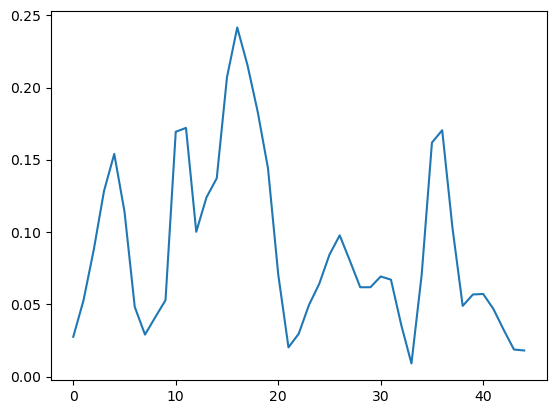

In [18]:
ap = utils.periodic_power(all_sounds[0], 1000, 500)
plt.plot(ap[15:60])
np.mean(ap[15:60])

testing for  spafe.features.mfcc.mfcc


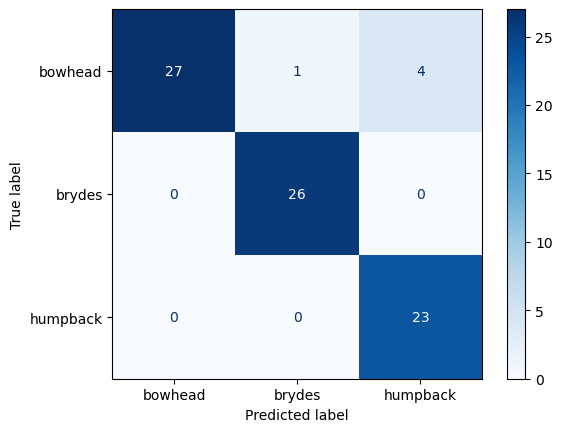

In [24]:
# processing
# snr needs to be updated here,

process_methods = [
    process_method_base.ProcessMethodBase(snr_db=15, reverb=False, signal_average_power=0.1),
    # process_method_base.ProcessMethodBase(snr_db=15, reverb=False),
    # process_method_base.ProcessMethodBase(snr_db=5, reverb=False),
    # process_method_base.ProcessMethodBase(snr_db=40, reverb=True),
    # process_method_base.ProcessMethodBase(snr_db=15, reverb=True),
    # process_method_base.ProcessMethodBase(snr_db=5, reverb=True),
]

fe_methods = [
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
]

# noise_average_power = 0.1 / 0.25
# noise_example = np.random.normal(0, np.sqrt(noise_average_power), 1000)

classifiers = {}
for i in range(len(fe_methods)):
    classifier = classifier_fhmm.ClassifierFHMM(fe_methods[i], process_methods[i])
    classifier.set_normalisation(adsNorm)
    classifier.train(adsTrain)
    classifier.train_noise_hmm()
    classifier.adapt_speaker_models()
    classifier.test(adsNorm)
